In [1]:
import MDAnalysis as mda
import pandas as pd
import numpy as np

import warnings
# suppress some MDAnalysis warnings about PSF files
warnings.filterwarnings('ignore')

from MDAnalysis.analysis import rms, align
from matplotlib import pyplot as plt

# add path in order to import the module
import sys
sys.path.append('/Users/ferdinandtolkes/whk/code')
from md_with_schnet.utils import set_plotting_config, get_bin_number
from md_with_schnet.setup_logger import setup_logger

logger = setup_logger("debug")
print("Using MDAnalysis version", mda.__version__)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

/Users/ferdinandtolkes/miniconda3/envs/schnet/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using MDAnalysis version 2.9.0


In [2]:
# Note: xyz files from ASE use units of eV, Angstroms and atomic masses
path_to_xyz = "./runs/MOTOR_MD_XTB_T300_1_epochs_1000_bs_100_lr_0.0001_seed_42/md_sim_steps_10000_time_step_0.5_seed_42/"
u_xtb = mda.Universe(f"{path_to_xyz}/xtb_traj.xyz", format='XYZ')
u_nn = mda.Universe(f"{path_to_xyz}/nn_traj.xyz", format='XYZ')
print(u_xtb)
print(u_nn)
print(len(u_xtb.trajectory))
print(len(u_nn.trajectory))

INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute types has been guessed successfully.
INFO:MDAnalysis.core.universe:attribute masses has been guessed successfully.


<Universe with 48 atoms>
<Universe with 48 atoms>
10001
10001


In [3]:
print(u_xtb.atoms.names)
print(u_xtb.atoms.masses)
print(u_xtb.atoms.positions.shape)
print(u_xtb.atoms.center_of_mass())

print(u_nn.atoms.names)
print(u_nn.atoms.masses)
print(u_nn.atoms.positions.shape)
print(u_nn.atoms.center_of_mass())

['O' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H']
[15.999 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011
 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011
 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011  1.008  1.008
  1.008  1.008  1.008  1.008  1.008  1.008  1.008  1.008  1.008  1.008
  1.008  1.008  1.008  1.008  1.008  1.008  1.008  1.008]
(48, 3)
[ 7.64441607e-07 -2.03634362e-06  9.38700904e-07]
['O' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C'
 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'
 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H']
[15.999 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011
 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011
 12.011 12.011 12.011 12.011 12.011 12.011 12.011 12.011  1.008  1

In [4]:
rgyr_xtb = []
rgyr_nn = []
time = []
for ts in u_xtb.trajectory:
    time.append(u_xtb.trajectory.time)
    rgyr_xtb.append(u_xtb.atoms.radius_of_gyration())
for ts in u_nn.trajectory:
    rgyr_nn.append(u_nn.atoms.radius_of_gyration())

In [5]:
rgyr_xtb_df = pd.DataFrame(rgyr_xtb, columns=['Radius of gyration (A)'], index=time)
rgyr_xtb_df.index.name = 'Time (ps)'

rgyr_nn_df = pd.DataFrame(rgyr_nn, columns=['Radius of gyration (A)'], index=time)
rgyr_nn_df.index.name = 'Time (ps)'

rgyr_xtb_df.head()
rgyr_nn_df.head()

,Radius of gyration (A)
Time (ps),
0.0,3.514854
1.0,3.515099
2.0,3.515348
3.0,3.515601
4.0,3.515858


2025-06-03 15:16:37,686 - md_with_schnet.utils - DEBUG - Finished setting up plotting configuration:
2025-06-03 15:16:37,687 - md_with_schnet.utils - DEBUG - fontsize: 10
2025-06-03 15:16:37,687 - md_with_schnet.utils - DEBUG - aspect_ratio: 2.0
2025-06-03 15:16:37,687 - md_with_schnet.utils - DEBUG - width_fraction: 1


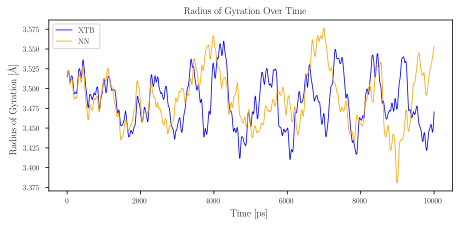

In [6]:
# plotting the radius of gyration for both XTB and NN over time
set_plotting_config(10, 8/4, 1)
plt.plot(rgyr_xtb_df.index, rgyr_xtb_df['Radius of gyration (A)'], label='XTB', color='blue')
plt.plot(rgyr_nn_df.index, rgyr_nn_df['Radius of gyration (A)'], label='NN', color='orange')
plt.xlabel('Time [ps]')
plt.ylabel('Radius of Gyration [$\mathrm{\AA}$]')
plt.legend()
plt.title('Radius of Gyration Over Time')
plt.show()

2025-06-03 15:16:38,005 - md_with_schnet.utils - DEBUG - Finished setting up plotting configuration:
2025-06-03 15:16:38,005 - md_with_schnet.utils - DEBUG - fontsize: 10
2025-06-03 15:16:38,006 - md_with_schnet.utils - DEBUG - aspect_ratio: 2.0
2025-06-03 15:16:38,006 - md_with_schnet.utils - DEBUG - width_fraction: 1
2025-06-03 15:16:38,007 - md_with_schnet.utils - DEBUG - Calculated number of bins: 28 for data with shape (10001,)
2025-06-03 15:16:38,007 - md_with_schnet.utils - DEBUG - Calculated number of bins: 35 for data with shape (10001,)


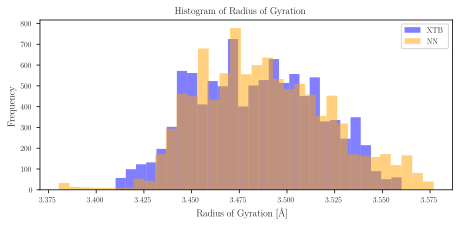

In [7]:
# plotting histograms of the radius of gyration for both XTB and NN
set_plotting_config(10, 8/4, 1)
n_bins_xtb = get_bin_number(rgyr_xtb_df['Radius of gyration (A)'].values)
n_bins_nn = get_bin_number(rgyr_nn_df['Radius of gyration (A)'].values)

plt.hist(rgyr_xtb_df['Radius of gyration (A)'], bins=n_bins_xtb, alpha=0.5, label='XTB', color='blue')
plt.hist(rgyr_nn_df['Radius of gyration (A)'], bins=n_bins_nn, alpha=0.5, label='NN', color='orange')
plt.xlabel('Radius of Gyration [$\mathrm{\AA}$]')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Radius of Gyration')
plt.show()

In [ ]:
def check_reference_frames_match(u_xtb: mda.Universe, u_nn: mda.Universe) -> np.ndarray:
    """
    Ensure the initial frames of both trajectories match.
    Args:
        u_xtb (mda.Universe): Universe object for the XTB trajectory.
        u_nn (mda.Universe): Universe object for the NN trajectory.
    Returns:
        np.ndarray: The reference frame positions from the XTB trajectory.
    Raises:
        ValueError: If the reference frames of the two trajectories do not match.
    """
    ref_xtb = u_xtb.trajectory[0].positions.copy()
    ref_nn = u_nn.trajectory[0].positions
    if not np.array_equal(ref_xtb, ref_nn):
        raise ValueError("Reference frames of XTB and NN trajectories do not match.")
    return ref_xtb


def compute_rmsd_trajectories(u_xtb: mda.Universe, u_nn: mda.Universe) -> pd.DataFrame:
    """
    Compute RMSD values for each timestep of two trajectories.
    Args:
        u_xtb (mda.Universe): Universe object for the XTB trajectory.
        u_nn (mda.Universe): Universe object for the NN trajectory.
    Returns:
        pd.DataFrame: DataFrame containing RMSD values for XTB, NN, and their comparison.
    Raises:
        ValueError: If the time steps of the two trajectories do not match.
        ValueError: If the reference frames of the two trajectories do not match.
    """
    reference_frame = check_reference_frames_match(u_xtb, u_nn)

    rmsd_comparison = []
    rmsd_xtb = []
    rmsd_nn = []
    time = []

    for xtb_ts, nn_ts in zip(u_xtb.trajectory, u_nn.trajectory):
        if xtb_ts.time != nn_ts.time:
            raise ValueError("Time mismatch between XTB and NN trajectories.")

        rmsd_comparison.append(rms.rmsd(xtb_ts.positions, nn_ts.positions))
        rmsd_xtb.append(rms.rmsd(xtb_ts.positions, reference_frame))
        rmsd_nn.append(rms.rmsd(nn_ts.positions, reference_frame))
        time.append(xtb_ts.time)

    return pd.DataFrame({
        'RMSD XTB (A)': rmsd_xtb,
        'RMSD NN (A)': rmsd_nn,
        'RMSD Comparison (A)': rmsd_comparison
    }, index=pd.Index(time, name='Time (ps)'))


rmsd_analysis = compute_rmsd_trajectories(u_xtb, u_nn)
print(rmsd_analysis.head())


           RMSD XTB (A)  RMSD NN (A)  RMSD Comparison (A)
Time (ps)                                                
0.0            0.000000     0.000000             0.000000
1.0            0.009466     0.009463             0.000032
2.0            0.018344     0.018329             0.000128
3.0            0.026424     0.026381             0.000283
4.0            0.033575     0.033487             0.000495


2025-06-03 15:16:40,608 - md_with_schnet.utils - DEBUG - Finished setting up plotting configuration:
2025-06-03 15:16:40,609 - md_with_schnet.utils - DEBUG - fontsize: 10
2025-06-03 15:16:40,610 - md_with_schnet.utils - DEBUG - aspect_ratio: 2.0
2025-06-03 15:16:40,610 - md_with_schnet.utils - DEBUG - width_fraction: 1


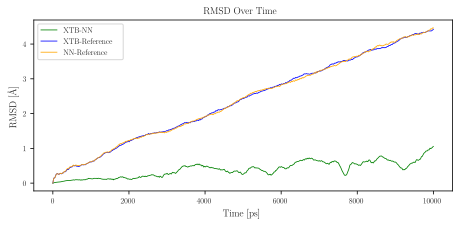

In [10]:
# Plotting the RMSD over time
set_plotting_config(10, 8/4, 1)
plt.plot(rmsd_analysis.index, rmsd_analysis['RMSD Comparison (A)'], label='XTB-NN', color='green')
plt.plot(rmsd_analysis.index, rmsd_analysis['RMSD XTB (A)'], label='XTB-Reference', color='blue')
plt.plot(rmsd_analysis.index, rmsd_analysis['RMSD NN (A)'], label='NN-Reference', color='orange')
plt.xlabel('Time [ps]')
plt.ylabel(r'RMSD [$\mathrm{\AA}$]')
plt.legend()
plt.title('RMSD Over Time')
plt.show()

In [11]:
def compute_rmsf(universe: mda.Universe, ref_frame: int = 0) -> np.ndarray:
    """
    Compute the root mean square fluctuation (RMSF) of the atoms in a given universe.
    Args:
        universe (mda.Universe): The MDAnalysis universe containing the trajectory.
        ref_frame (int): The index of the reference frame to align against.
    Returns:
        np.ndarray: The RMSF values for each atom.
    """
    if ref_frame < 0 or ref_frame >= len(universe.trajectory):
        raise ValueError(f"Reference frame index {ref_frame} is out of bounds for the trajectory with {len(universe.trajectory)} frames.")
    # Align the trajectory to the reference frame and compute RMSF
    avg = align.AverageStructure(universe, universe, ref_frame=ref_frame).run()
    ref = avg.results.universe
    align.AlignTraj(universe, ref, in_memory=True).run()
    results = rms.RMSF(universe.atoms).run()
    logger.debug(f"RMSF computed for {len(universe.atoms)} atoms over {len(universe.trajectory)} frames.")
    return results.rmsf

# Compute RMSF for both XTB and NN trajectories
rmsf_xtb = compute_rmsf(u_xtb, ref_frame=0)
rmsf_nn = compute_rmsf(u_nn, ref_frame=0)

INFO:MDAnalysis.analysis.align:Moved mobile trajectory to in-memory representation
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
INFO:MDAnalysis.analysis.base:Finishing up
2025-06-03 15:16:42,856 - __main__ - DEBUG - RMSF computed for 48 atoms over 10001 frames.
INFO:MDAnalysis.analysis.align:Moved mobile trajectory to in-memory representation
INFO:MDAnalysis.analysis.base:Choosing frames to analyze
INFO:MDAnalysis.analysis.base:Starting preparation
INFO:MDAnalysis.analysis.base:Finishing up
2025-06-03 15:16:44,805 - __main__ - DEBUG - RMSF computed for 48 atoms over 10001 frames.


2025-06-03 15:16:44,811 - md_with_schnet.utils - DEBUG - Finished setting up plotting configuration:
2025-06-03 15:16:44,813 - md_with_schnet.utils - DEBUG - fontsize: 10
2025-06-03 15:16:44,813 - md_with_schnet.utils - DEBUG - aspect_ratio: 2.0
2025-06-03 15:16:44,813 - md_with_schnet.utils - DEBUG - width_fraction: 1


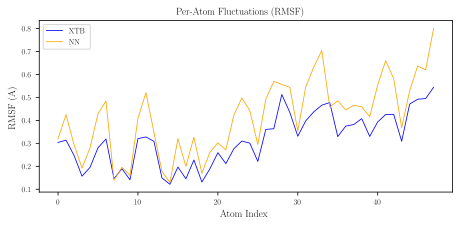

In [12]:
# plot per-atom fluctuations for XTB
set_plotting_config(10, 8/4, 1)
plt.plot(u_xtb.atoms.indices, rmsf_xtb, label='XTB', color='blue')
plt.plot(u_nn.atoms.indices, rmsf_nn, label='NN', color='orange')
plt.xlabel('Atom Index')
plt.ylabel('RMSF (A)')
plt.legend()
plt.title('Per-Atom Fluctuations (RMSF)')
plt.show()

In [13]:
# Compute all interatomic distances over the trajectory and compare distributions
def compute_interatomic_distances(universe: mda.Universe) -> np.ndarray:
    """
    Compute interatomic distances for all frames in the trajectory.
    Args:
        universe (mda.Universe): The MDAnalysis universe object containing the trajectory.
    Returns:
        np.ndarray: An array of interatomic distances for each frame.
    """
    distances = []
    for ts in universe.trajectory:
        dist = mda.lib.distances.distance_array(
            ts.positions, ts.positions)
        distances.append(dist[np.triu_indices_from(dist, k=1)])
    np_distances = np.array(distances)
    logger.debug(f"Computed interatomic distances: {np_distances.shape}")
    return np_distances

distances_xtb = compute_interatomic_distances(u_xtb)
distances_nn = compute_interatomic_distances(u_nn)

dists_xtb_flatten = distances_xtb.flatten()
dists_nn_flatten = distances_nn.flatten()

2025-06-03 15:16:45,227 - __main__ - DEBUG - Computed interatomic distances: (10001, 1128)
2025-06-03 15:16:45,506 - __main__ - DEBUG - Computed interatomic distances: (10001, 1128)


2025-06-03 15:16:45,553 - md_with_schnet.utils - DEBUG - Finished setting up plotting configuration:
2025-06-03 15:16:45,553 - md_with_schnet.utils - DEBUG - fontsize: 10
2025-06-03 15:16:45,553 - md_with_schnet.utils - DEBUG - aspect_ratio: 2.0
2025-06-03 15:16:45,554 - md_with_schnet.utils - DEBUG - width_fraction: 1
2025-06-03 15:16:45,583 - md_with_schnet.utils - DEBUG - Calculated number of bins: 332 for data with shape (11281128,)
2025-06-03 15:16:45,611 - md_with_schnet.utils - DEBUG - Calculated number of bins: 334 for data with shape (11281128,)


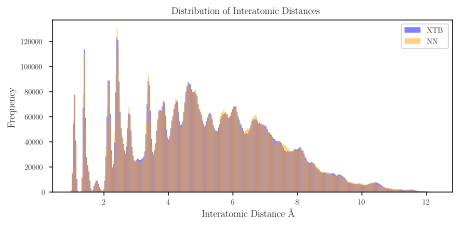

In [14]:
# plot and compare the distributions of interatomic distances
set_plotting_config(10, 8/4, 1)
n_bins_xtb = get_bin_number(dists_xtb_flatten)
n_bins_nn = get_bin_number(dists_nn_flatten)
n_bins = max(n_bins_xtb, n_bins_nn)

plt.hist(dists_xtb_flatten, bins=n_bins, alpha=0.5, label='XTB', color='blue')
plt.hist(dists_nn_flatten, bins=n_bins, alpha=0.5, label='NN', color='orange')
plt.xlabel('Interatomic Distance $\mathrm{\AA}$')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Interatomic Distances')
plt.show()